# Part B: Fast price approximator to time dependent derivatives

### Importing Libraries

In [8]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.optimizers.legacy import Adam
import time
import itertools
import matplotlib.pyplot as plt

## MonteCarlo Functions 

In [37]:
def generate_random_paths(num_paths, num_steps, initial_price, drift_rate, volatility, time_to_maturity):
    """
    Generate random paths of the underlying asset using geometric Brownian motion.

    Parameters:
    - num_paths: Number of paths to generate.
    - num_steps: Number of time steps in each path.
    - initial_price: Initial price of the underlying asset.
    - drift_rate: Annual drift rate (e.g., risk-free interest rate).
    - volatility: Annual volatility of the asset's returns.
    - time_to_maturity: Time to maturity of the derivative.

    Returns:
    - paths: A NumPy array of shape (num_paths, num_steps) containing the simulated paths.
    - time_grid: A NumPy array of shape (num_steps,) representing the time points.
    """
    dt = time_to_maturity / num_steps
    sqrt_dt = np.sqrt(dt)

    # Generate random samples from a standard normal distribution
    rand_samples = np.random.randn(num_paths, num_steps)

    # Create an array to store the paths
    paths = np.zeros((num_paths, num_steps))

    # Set the initial prices
    paths[:, 0] = initial_price

    for t in range(1, num_steps):
        # Calculate the drift and stochastic components
        drift = (drift_rate - 0.5 * volatility ** 2) * dt
        stochastic = volatility * sqrt_dt * rand_samples[:, t]

        # Update the asset prices using geometric Brownian motion
        paths[:, t] = paths[:, t - 1] * np.exp(drift + stochastic)

    # Create the time grid
    time_grid = np.linspace(0, time_to_maturity, num_steps)

    return paths, time_grid

In [38]:
def binary_option_price(num_paths, num_steps, initial_price, drift_rate, volatility, time_to_maturity, strike_price, barrier_price, option_type='up-and-out', r=0.05):
    """
    Calculate the price of a binary option based on simulated paths of the underlying asset.

    Parameters:
    - num_paths: Number of paths to generate.
    - num_steps: Number of time steps in each path.
    - initial_price: Initial price of the underlying asset.
    - drift_rate: Annual drift rate (e.g., risk-free interest rate).
    - volatility: Annual volatility of the asset's returns.
    - time_to_maturity: Time to maturity of the derivative.
    - strike_price: Strike price of the binary option.
    - barrier_price: Barrier price for the binary option.
    - option_type: Type of binary option ('up-and-out', 'down-and-out', 'up-and-in', or 'down-and-in').
    - r: Risk-free interest rate.

    Returns:
    - option_price: The estimated price of the binary option.
    """
    paths, _ = generate_random_paths(num_paths, num_steps, initial_price, drift_rate, volatility, time_to_maturity)
    num_paths, num_steps = paths.shape

    if option_type == 'up-and-out':
        option_payoffs = np.where(np.max(paths, axis=1) >= barrier_price, 0, np.where(np.max(paths, axis=1) >= strike_price, 1, 0))
    elif option_type == 'down-and-out':
        option_payoffs = np.where(np.min(paths, axis=1) <= barrier_price, 0, np.where(np.min(paths, axis=1) <= strike_price, 1, 0))
    elif option_type == 'up-and-in':
        option_payoffs = np.where(np.max(paths, axis=1) >= barrier_price, 1, np.where(np.max(paths, axis=1) >= strike_price, 0, 0))
    elif option_type == 'down-and-in':
        option_payoffs = np.where(np.min(paths, axis=1) <= barrier_price, 1, np.where(np.min(paths, axis=1) <= strike_price, 0, 0))
    else:
        raise ValueError("Invalid option_type. Use 'up-and-out', 'down-and-out', 'up-and-in', or 'down-and-in'.")

    # Calculate the option price by taking the average of the payoffs and discounting it
    option_price = np.exp(-r * time_to_maturity) * np.mean(option_payoffs)

    return option_price

In [39]:
def asian_option_price(num_paths, num_steps, initial_price, drift_rate, volatility, time_to_maturity, strike_price, option_type='call', r=0.05):
    """
    Calculate the price of an Asian option based on simulated paths of the underlying asset.

    Parameters:
    - num_paths: Number of paths to generate.
    - num_steps: Number of time steps in each path.
    - initial_price: Initial price of the underlying asset.
    - drift_rate: Annual drift rate (e.g., risk-free interest rate).
    - volatility: Annual volatility of the asset's returns.
    - time_to_maturity: Time to maturity of the derivative.
    - strike_price: Strike price of the Asian option.
    - option_type: Type of Asian option ('call' or 'put').
    - r: Risk-free interest rate.

    Returns:
    - option_price: The estimated price of the Asian option.
    """
    paths, _ = generate_random_paths(num_paths, num_steps, initial_price, drift_rate, volatility, time_to_maturity)
    num_paths, num_steps = paths.shape
    average_prices = np.mean(paths, axis=1)  # Calculate the average price for each path

    if option_type == 'call':
        option_payoffs = np.maximum(average_prices - strike_price, 0)
    elif option_type == 'put':
        option_payoffs = np.maximum(strike_price - average_prices, 0)
    else:
        raise ValueError("Invalid option_type. Use 'call' or 'put'.")

    # Calculate the option price by taking the average of the payoffs and discounting it
    option_price = np.exp(-r * time_to_maturity) * np.mean(option_payoffs)
    std_deviation = np.std(option_payoffs)
    
    return option_price, std_deviation
    

In [40]:
# Example usage:
num_paths = 1000
num_steps = 252  # Daily time steps for one year
initial_price = 100.0
drift_rate = 0.05  # 5% annual risk-free interest rate
volatility = 0.2   # 20% annual volatility
time_to_maturity = 1.0  # 1 year

# Asian option
strike_price = 100.0
option_type = 'call'
r = 0.05  # Risk-free interest rate
T = 1.0   # Time to maturity

asian_option_price_real,_ = asian_option_price(num_paths, num_steps, initial_price, drift_rate, volatility, time_to_maturity, strike_price, option_type)
print(f"Asian {option_type} option price: {asian_option_price_real:.2f}")

# Binary option
strike_price = 100.0
barrier_price = 110.0
option_type = 'up-and-in'
r = 0.05  # Risk-free interest rate
T = 1.0   # Time to maturity

binary_option_price_real = binary_option_price(num_paths, num_steps, initial_price, drift_rate, volatility, time_to_maturity, strike_price, barrier_price, option_type)
print(f"Binary {option_type} option price: {binary_option_price_real:.2f}")

Asian call option price: 5.86
Binary up-and-in option price: 0.62


# Construction of the Database of Derivatives Prices

In [ ]:
# Define the parameter ranges
#stock_prices = range(1, 200,4)
#interest_rates = np.arange(0, 0.08, 0.01)
#volatilities = np.arange(0, 0.9, 0.05)
#strike_prices = range(1, 400,5)
#time_to_maturity=[6/12,1]
# Create an empty list to store the results as dictionaries
#results_list = []

# Loop through the parameter combinations and calculate option prices
#c=0
#size=(len(stock_prices)*len(interest_rates)*len(volatilities)*len(strike_prices)*len(time_to_maturity))
#print(size)
#for stock_price in stock_prices:
#    for interest_rate in interest_rates:
#        for volatility in volatilities:
#            for strike_price in strike_prices:
#                for tmt in time_to_maturity:
#                    option_price_value = asian_option_price(num_paths, num_steps, stock_price, interest_rate, volatility, tmt, strike_price, option_type='call')
#                    result_dict = {
#                    'Stock Price': stock_price,
#                    'Interest Rate': interest_rate,
#                    'Volatility': volatility,
#                    'Time to Maturity' : tmt,
#                    'Strike Price': strike_price,
#                    'Option Price': option_price_value[0]
#                    }
#                    results_list.append(result_dict)
#                    c+=1
#                    if c%200000==0:
#                        #to free Memory space
#                        print(f"{c/size*100} %")
#                        temp_df = pd.DataFrame(results_list)    
#                        temp_df.to_csv(f"derivatives_price{c}.csv")
#                        del temp_df
#                        results_list=[]

# Create last Df
#temp_df = pd.DataFrame(results_list)    
#temp_df.to_csv(f"derivatives_price{c}.csv")


In [3]:
#Load all df and concat in one df to export as one csv
#df=pd.DataFrame()
#for k in ['derivatives_price200000.csv','derivatives_price400000.csv','derivatives_price600000.csv','derivatives_price800000.csv','derivatives_price1000000.csv','derivatives_price1152000.csv']:
#    temp=pd.read_csv(k)
#    df=pd.concat([df,temp],axis=0)
#print(df.shape)
#df.to_csv('Derivatives_prices.csv')
#print('Data Saved')

(1152000, 7)
Data Saved


# Load Directly Database Constructed

In [10]:
df = pd.read_csv("Derivatives_prices.csv")

# Neural Network Construction and Hyper-Parameters Tuning

In [11]:
# Separate the target values (derivative prices) and features
y = df['Option Price']
X = df.drop(columns=['Option Price'])  # Exclude the target column

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalize input features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test_save=X_test
X_test = scaler.transform(X_test)

In [12]:
# Define a function to create and train the neural network with given hyperparameters
def create_and_train_model(neurons_per_layer, total_epochs, X_train, y_train, X_val, y_val,activator):
    # Build the neural network architecture
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(X_train.shape[1],)),  # Input layer
        # Add hidden layers with the specified number of neurons
        *[tf.keras.layers.Dense(neurons, activation=activator) for neurons in neurons_per_layer],
        # Output layer
        tf.keras.layers.Dense(1, activation='softplus')
    ])

    learning_rate_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=10000,
    decay_rate=0.97)
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=learning_rate_schedule), loss='mean_squared_error')

    # Train the model
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=total_epochs, batch_size=32, verbose=2)

    return model, history

In [106]:
# Define hyperparameter grids
neurons_per_layer_grid = [[10],[64],[10, 10],[64, 64],[10, 10, 10],[64, 64, 64]]  # Example values for the number of neurons in each layer
total_epochs_grid = [100]  # Example values for the total number of epochs
activators = ['relu','softmax']

# Initialize lists to store results
models = []
histories = []

# Iterate through the hyperparameter grids
for neurons_per_layer, total_epochs, activator in itertools.product(neurons_per_layer_grid, total_epochs_grid,activators):
    # Create and train the model with the current hyperparameters
    model, history = create_and_train_model(neurons_per_layer, total_epochs, X_train, y_train, X_val, y_val, activator)

    # Append the trained model and history to the lists
    models.append(model)
    histories.append(history)

Epoch 1/100
25200/25200 - 12s - loss: 16.5936 - val_loss: 1.7784 - 12s/epoch - 465us/step
Epoch 2/100
25200/25200 - 12s - loss: 1.3626 - val_loss: 0.9607 - 12s/epoch - 458us/step
Epoch 3/100
25200/25200 - 12s - loss: 0.7672 - val_loss: 0.6512 - 12s/epoch - 459us/step
Epoch 4/100
25200/25200 - 12s - loss: 0.6954 - val_loss: 0.6138 - 12s/epoch - 459us/step
Epoch 5/100
25200/25200 - 13s - loss: 0.6493 - val_loss: 0.6351 - 13s/epoch - 534us/step
Epoch 6/100
25200/25200 - 13s - loss: 0.6186 - val_loss: 0.6156 - 13s/epoch - 525us/step
Epoch 7/100
25200/25200 - 12s - loss: 0.6015 - val_loss: 0.7214 - 12s/epoch - 460us/step
Epoch 8/100
25200/25200 - 12s - loss: 0.5925 - val_loss: 0.6145 - 12s/epoch - 461us/step
Epoch 9/100
25200/25200 - 12s - loss: 0.5861 - val_loss: 0.5576 - 12s/epoch - 458us/step
Epoch 10/100
25200/25200 - 13s - loss: 0.5804 - val_loss: 0.5870 - 13s/epoch - 528us/step
Epoch 11/100
25200/25200 - 12s - loss: 0.5753 - val_loss: 0.5729 - 12s/epoch - 463us/step
Epoch 12/100
25200

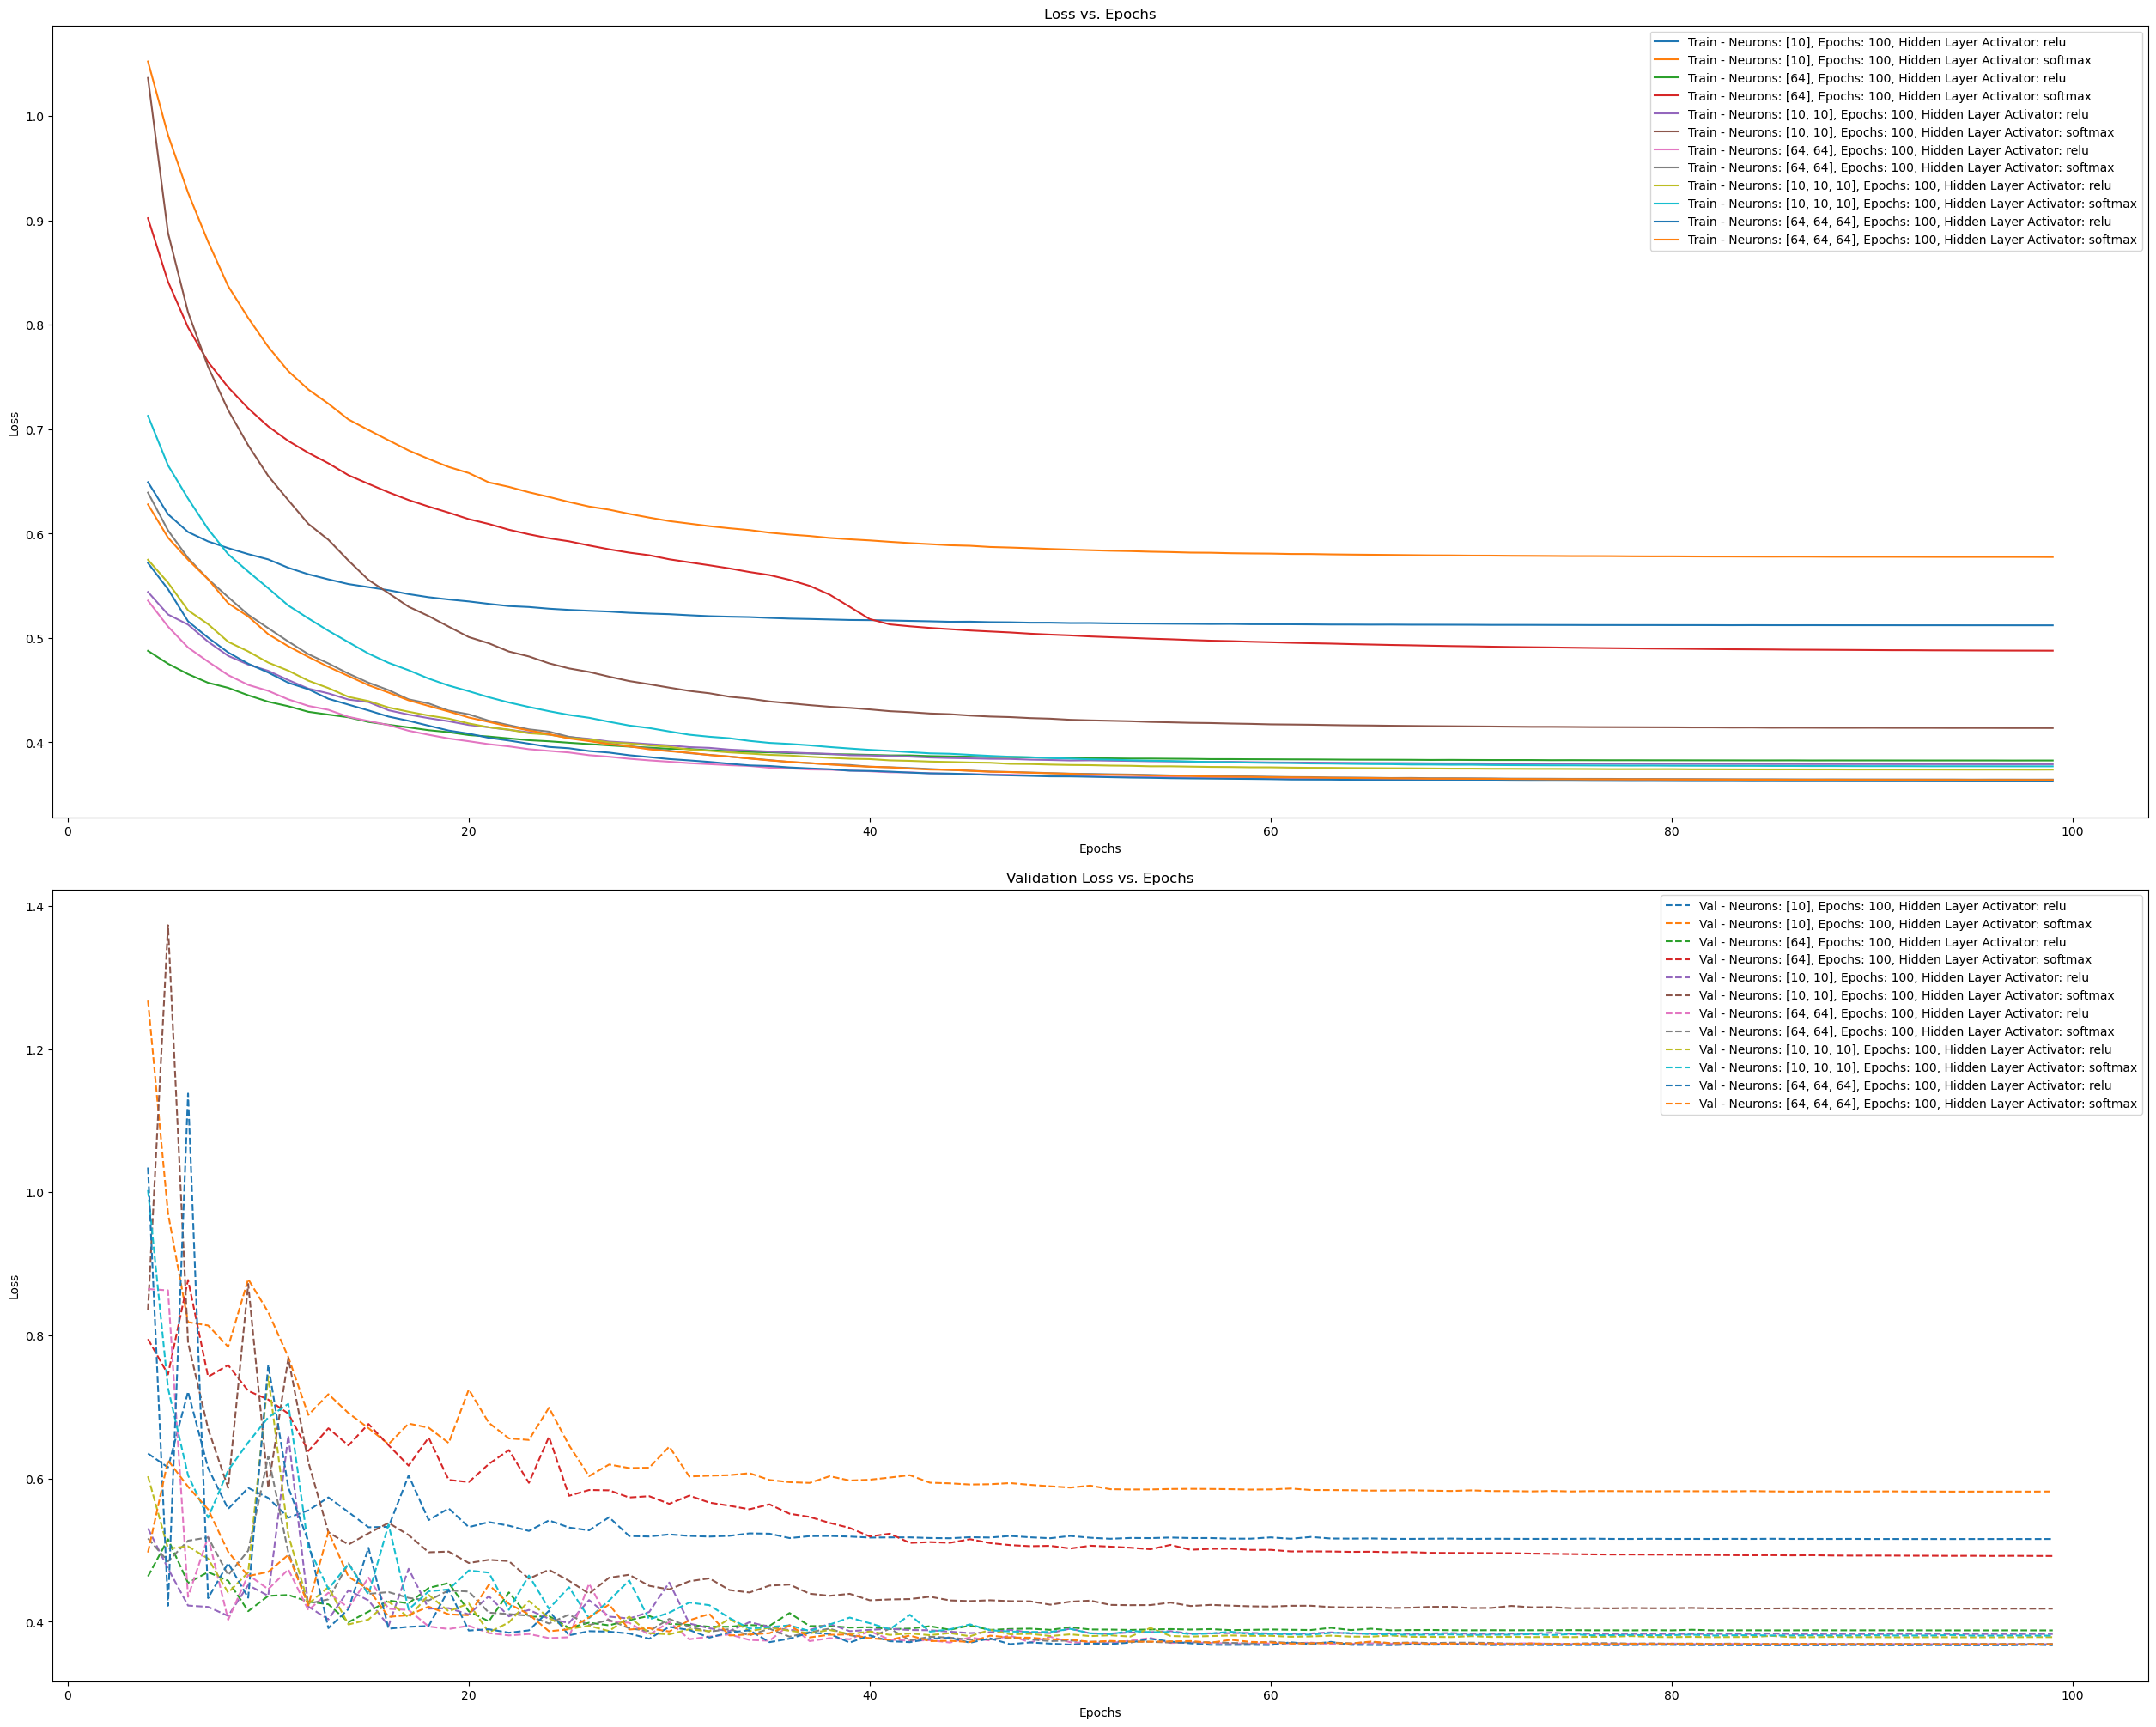

In [107]:
# Create a line plot to visualize loss and validation loss
fig, axs = plt.subplots(2, 1, figsize=(25, 20),sharex=False,layout='constrained') 

for i, (neurons_per_layer, total_epochs, activator) in enumerate(itertools.product(neurons_per_layer_grid, total_epochs_grid, activators)):
    history = histories[i]
    label = f"Neurons: {neurons_per_layer}, Epochs: {total_epochs}, Hidden Layer Activator: {activator}"
    # Plot training loss
    axs[0].plot(history.epoch[4:], history.history['loss'][4:], label=f"Train - {label}")
    # Plot validation loss
    axs[1].plot(history.epoch[4:], history.history['val_loss'][4:], label=f"Val - {label}", linestyle='--')
    axs[0].set_title('Loss vs. Epochs')
    axs[1].set_title('Validation Loss vs. Epochs')
    for j in [0,1]:    
        axs[j].set_xlabel('Epochs')
        axs[j].set_ylabel('Loss')
        axs[j].legend()
        axs[j].grid()
    
plt.show()

In [108]:
#Export all models
names =[]
for i, (neurons_per_layer, total_epochs,activator) in enumerate(itertools.product(neurons_per_layer_grid, total_epochs_grid,activators)):
    history = histories[i]
    label = f"Hiden_Layers_{'_'.join([str(i) for i in neurons_per_layer])}_{activator}"
    names.append(label)
    models[i].save(f"{label}.h5")
    print(f"{label}.h5 exported")
    

Hiden_Layers_10_relu.h5 exported
Hiden_Layers_10_softmax.h5 exported
Hiden_Layers_64_relu.h5 exported
Hiden_Layers_64_softmax.h5 exported
Hiden_Layers_10_10_relu.h5 exported
Hiden_Layers_10_10_softmax.h5 exported
Hiden_Layers_64_64_relu.h5 exported
Hiden_Layers_64_64_softmax.h5 exported
Hiden_Layers_10_10_10_relu.h5 exported
Hiden_Layers_10_10_10_softmax.h5 exported
Hiden_Layers_64_64_64_relu.h5 exported
Hiden_Layers_64_64_64_softmax.h5 exported


/Users/Louis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [130]:
minimum_mse = 100
best_model_name = None
best_model = None
for i in range(len(models)):
    y_pred = models[i].predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    if mse<minimum_mse:
        minimum_mse = mse
        best_model_name = names[i]
        best_model = models[i]
    print(f"{names[i]} Mean Squared Error on Test Set: {mse}")
print(f"\nBest model : {best_model_name} with Mean Squared Error on Test Set: {minimum_mse}")

5400/5400 [==============================] - 2s 360us/step
Hiden_Layers_10_relu Mean Squared Error on Test Set: 0.5118633164983393
5400/5400 [==============================] - 2s 353us/step
Hiden_Layers_10_softmax Mean Squared Error on Test Set: 0.5794209479475737
5400/5400 [==============================] - 2s 365us/step
Hiden_Layers_64_relu Mean Squared Error on Test Set: 0.3838012617483963
5400/5400 [==============================] - 2s 366us/step
Hiden_Layers_64_softmax Mean Squared Error on Test Set: 0.49224456055399474
5400/5400 [==============================] - 7s 1ms/step
Hiden_Layers_10_10_relu Mean Squared Error on Test Set: 0.3798633528823766
5400/5400 [==============================] - 2s 397us/step
Hiden_Layers_10_10_softmax Mean Squared Error on Test Set: 0.414909810152602
5400/5400 [==============================] - 2s 396us/step
Hiden_Layers_64_64_relu Mean Squared Error on Test Set: 0.36602895766192767
5400/5400 [==============================] - 2s 394us/step
Hiden_L

# Comparison of Both Methods

In [128]:
#Comparison on 10 000 Derivatives
# Step 1: Predict with Neural Network
start_time_nn = time.time()
#We are going to use the 3 hidden layers with 64 neutrons each, it is the model that gives the best results
nn_predictions = best_model.predict(X_test[:10000])
nn_time = time.time() - start_time_nn
#print(len(X_test[:10000]))
# Step 2: Compute Monte Carlo prices with Confidence Intervals
start_time_mc = time.time()
mc_estimates = np.array([asian_option_price(num_paths=1000, 
                        num_steps=252, 
                        initial_price=x[0], 
                        drift_rate=x[1], 
                        volatility=x[2], 
                        time_to_maturity=x[3], 
                        strike_price=x[4], 
                        option_type='call',
                        r=0.05) 
     for x in X_test_save.iloc[:10000,1:].to_numpy()])
mc_time = time.time() - start_time_mc

# Unpack estimates and standard deviations
mc_prices, mc_std_devs = mc_estimates[:, 0], mc_estimates[:, 1]

# Step 3: Confidence Interval Calculation
# Calculate the 95% confidence interval
z_score = 1.96  # Z-score for 95% confidence
mc_confidence_intervals = z_score * (mc_std_devs / np.sqrt(1000))

# Step 4: Compile results into a DataFrame
results_df = pd.DataFrame({
    'Neural Network Fit': nn_predictions.flatten(),  # Flatten in case predictions have an extra dimension
    'Monte Carlo': mc_prices,
    'Confidence Interval Lower': mc_prices - mc_confidence_intervals,
    'Confidence Interval Upper': mc_prices + mc_confidence_intervals,
    'Value from First MC':y_test[:10000]
})

# Print out timings
print(f"Time to compute derivative prices using the neural network: {nn_time:.6f} seconds")
print(f"Time to compute derivative prices using Monte Carlo: {mc_time:.6f} seconds")

313/313 [==============================] - 0s 471us/step
Time to compute derivative prices using the neural network: 0.229993 seconds
Time to compute derivative prices using Monte Carlo: 107.851625 seconds


In [111]:
results_df

,Neural Network Fit,Monte Carlo,Confidence Interval Lower,Confidence Interval Upper,Value from First MC
91064,9.160605e+01,91.318333,89.923734,92.712932,91.941520
26045,3.269214e-18,0.000000,0.000000,0.000000,0.000000
35118,6.455122e+00,6.189018,4.775019,7.603016,5.956809
188626,7.002736e-14,0.000000,0.000000,0.000000,0.000000
153555,2.236152e-01,0.306902,0.013532,0.600272,0.322587
...,...,...,...,...,...
1633,1.656881e-05,0.000000,0.000000,0.000000,0.000000
104886,3.822152e-13,0.000000,0.000000,0.000000,0.000000
122837,4.320660e-02,0.028951,-0.030672,0.088573,0.127472
188994,5.147791e+01,50.936068,48.067811,53.804325,49.419324


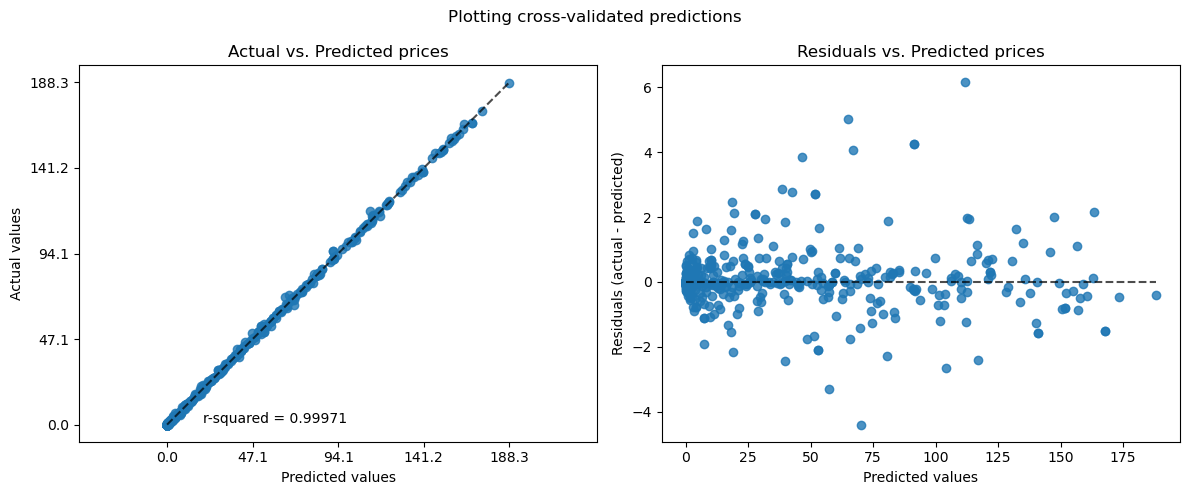

In [112]:
#Comparaison between predicted prices and real prices
from sklearn.metrics import PredictionErrorDisplay

y_pred_test,y_real_test = nn_predictions.flatten(), mc_prices
x = np.linspace(min(y_real_test),max(y_real_test),len(y_real_test))

fig, axs = plt.subplots(ncols=2, figsize=(12, 5))
PredictionErrorDisplay.from_predictions(
    y_real_test,
    y_pred=y_pred_test,
    kind="actual_vs_predicted",
    ax=axs[0],
    random_state=0,
)
axs[0].annotate("r-squared = {:.5f}".format(r2_score(y_real_test,y_pred_test)), (20,1), size = 10)
axs[0].set_title("Actual vs. Predicted prices")
PredictionErrorDisplay.from_predictions(
    y_real_test,
    y_pred=y_pred_test,
    kind="residual_vs_predicted",
    ax=axs[1],
    random_state=0,
)
axs[1].set_title("Residuals vs. Predicted prices")
fig.suptitle("Plotting cross-validated predictions")
plt.tight_layout()
plt.show()

##### The Neural Network is within MonteCarlo Boundaries and is way mode efficient